In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm

from bikebench.rendering import animation

from bikebench.data_loading import data_loading
from bikebench.conditioning import conditioning
from bikebench.design_evaluation import design_evaluation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Using java as the Java binary


/home/mileva/mambaforge/envs/bike-bench-cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = data_loading.load_bike_bench_train()
data_variance = torch.tensor(data.var().values, device=device, dtype=torch.float32)

In [3]:
evaluators = [design_evaluation.ErgonomicsEvaluator(penalize_constraints=False, device=device), design_evaluation.ValidationEvaluator(device=device)]
evaluator, requirement_names, is_objective, is_conditional = design_evaluation.construct_tensor_evaluator(evaluators, data.columns)
rider_condition = conditioning.sample_riders(1, split="test")
use_case_condition = conditioning.sample_use_case(1, split="test")
condition = {"Rider": rider_condition, "Use Case": use_case_condition}

In [4]:
with torch.no_grad():
    baseline_scores = evaluator(torch.tensor(data.values, dtype=torch.float32, device=device), condition)
score_std = baseline_scores.std(dim=0)

In [5]:
data.loc[[2647]][['FIRST color R_RGB', 'FIRST color G_RGB', 'FIRST color B_RGB']]

,FIRST color R_RGB,FIRST color G_RGB,FIRST color B_RGB
2647,0.0,0.0,102.0


Grab a weird non-ergonomic bike to optimize

In [75]:
data_gd = torch.tensor(data.loc[[2647]].values, dtype=torch.float32, device=device, requires_grad=True)

optimizer = torch.optim.Adam([data_gd], lr=0.1)  # tweak lr if needed

all_steps = [data_gd.detach().clone()]
all_losses = []
for i in tqdm(range(600)):
    scores = evaluator(data_gd, condition)
    scores = scores / score_std  # Normalize scores by standard deviation

    objective_scores = scores[:, np.array(is_objective, dtype=bool)]
    aggregate_objective_score = objective_scores.mean(dim=1)

    constraint_scores = scores[:, ~np.array(is_objective, dtype=bool)]
    thresholded_constraint_scores = torch.clamp(constraint_scores, min=0)
    aggregate_constraint_score = thresholded_constraint_scores.mean(dim=1)

    constraint_weight=10
    total_score = aggregate_objective_score + aggregate_constraint_score * constraint_weight

    all_losses.append(total_score.item())
    total_score.backward()


    with torch.no_grad():
        #exit if data_gd is not changing
        if data_gd.grad is None or torch.all(data_gd.grad.abs() < 1e-6):
            print("Gradient is zero, stopping optimization.")
            break
        data_gd -= 0.1 * data_gd.grad * data_variance #equivalent to gd on the normalized data
        # data_gd = torch.clamp(data_gd, min_values, max_values)
        

    data_gd.requires_grad_()
    data_gd.grad = None

    all_steps.append(data_gd.detach().clone())

all_steps_tensor = torch.stack(all_steps, dim=0).cpu()  # shape: (steps, 1, features)
steps_df = pd.DataFrame(all_steps_tensor.squeeze(1).numpy(), columns=data.columns)

 89%|████████▉ | 534/600 [00:19<00:02, 27.38it/s]

Gradient is zero, stopping optimization.


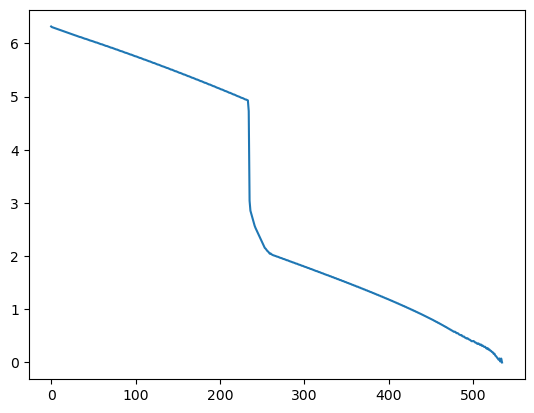

In [76]:
plt.plot(all_losses)

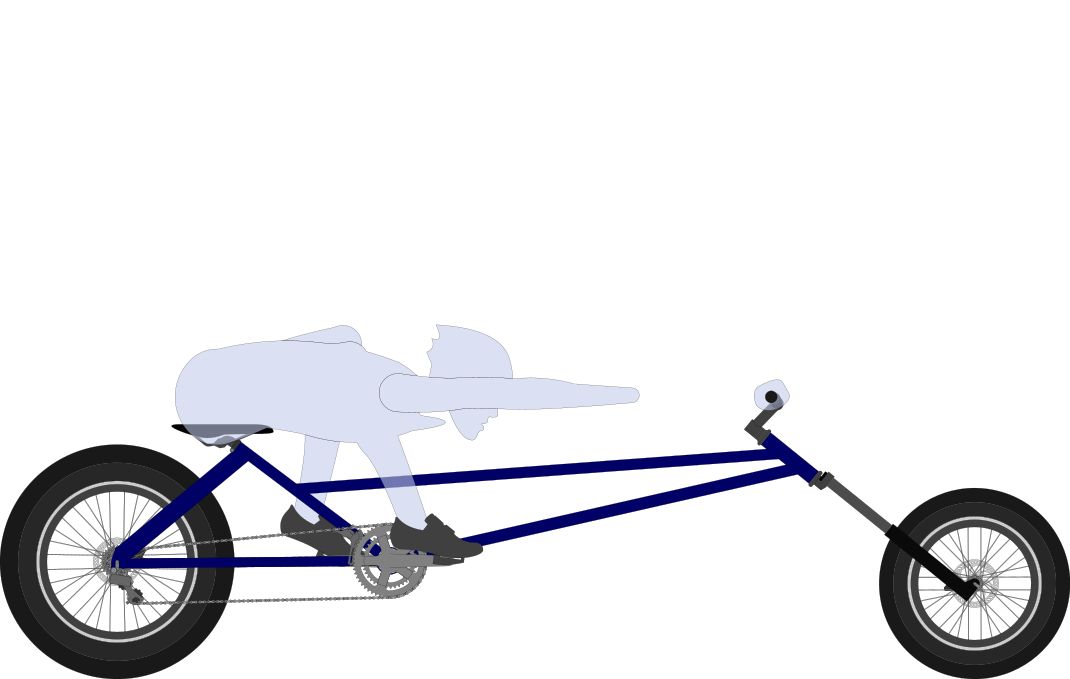

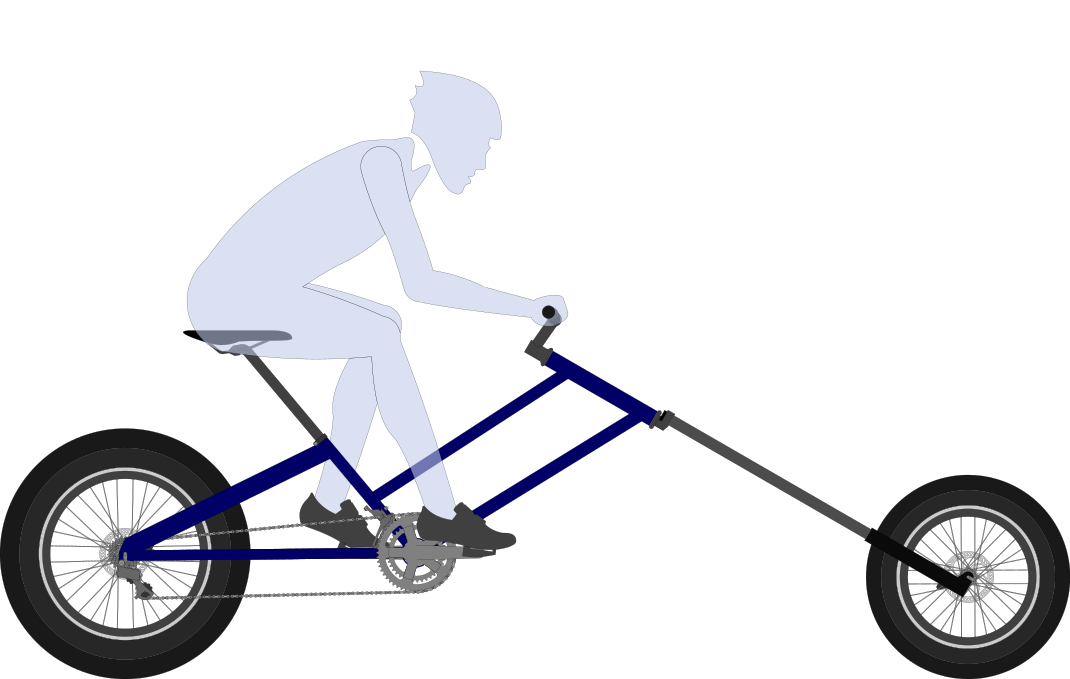

In [77]:
from bikebench.rendering import rendering
renderer = rendering.RenderingEngine(number_rendering_servers = 1, server_init_timeout_seconds=120)

#Initial
res = renderer.render_clip(steps_df.iloc[0], rider_dims=rider_condition)
svg = res.image_bytes
from IPython.display import SVG, display
display(SVG(svg))

#Final
res = renderer.render_clip(steps_df.iloc[-1], rider_dims=rider_condition)
svg = res.image_bytes
from IPython.display import SVG, display
display(SVG(svg))

In [78]:
frame_step_size = 6
idx = np.r_[np.arange(0, len(steps_df), frame_step_size), len(steps_df) - 1]
idx = np.unique(idx)  # avoid dup if last already included

steps_subset = steps_df.iloc[idx].reset_index(drop=True)
mp4 = animation.render_to_animation(steps_subset, fps=10, mp4_filename="ergonomics.mp4", rider_dims = rider_condition[0])

Rendering frames: 100%|██████████| 90/90 [02:57<00:00,  1.97s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1070, 679) to (1072, 688) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
